# Crisp Store Clustering


[![Open in Colab](https://img.shields.io/badge/Open%20in-Colab-orange?logo=google-colab&style=for-the-badge)](https://colab.research.google.com/github/gocrisp/analytics-blueprints-public/blob/main/notebooks/crisp_store_clustering.ipynb)
[![Open in Vertex AI](https://img.shields.io/badge/Open%20in-Vertex%20AI%20Workbench-brightgreen?logo=google-cloud&style=for-the-badge)](https://console.cloud.google.com/vertex-ai/notebooks/deploy-notebook?download_url=https://raw.githubusercontent.com/gocrisp/analytics-blueprints-public/main/notebooks/crisp_store_clustering.ipynb)
[![Open in Databricks](https://img.shields.io/badge/databricks-red?logo=databricks&style=for-the-badge)](https://www.databricks.com/try-databricks)
[![View on GitHub](https://img.shields.io/badge/View%20on-GitHub-lightgrey?logo=github&style=for-the-badge)](https://github.com/gocrisp/analytics-blueprints-public/blob/main/notebooks/crisp_store_clustering.ipynb)


This page shows you how to perform clustering on a dataset of store and sales data. The dataset is a combination of sales data, product category data, and store data. The goal is to cluster stores based on the sales of different product categories. Potentially, this insight can be used to find patterns in store sales and detect anomalies (e.g. phantom inventory, underperforming stores, etc.).


## Set the required environment variables

In [1]:
import os

os.environ["ACCOUNT_ID"] = "80047"
# os.environ["CONNECTOR_ID"] = None
# os.environ["OPENAI_API_KEY"] = ""

### Run Crisp common notebook

This notebook uses the [crisp_common.ipynb](./crisp_common.ipynb) notebook to load the common functions and variables. The `crisp_common.ipynb` notebook contains the common functions and variables that are used across the Crisp notebooks.

In [ ]:
import os

if not os.path.exists("crisp_common.ipynb"):
    print("Downloading crisp_common.ipynb")
    !wget https://raw.githubusercontent.com/gocrisp/analytics-blueprints-public/main/notebooks/crisp_common.ipynb -O crisp_common.ipynb
else:
    print("crisp_common.ipynb already exists")

%run crisp_common.ipynb

## Import dependencies

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field
import folium

### Add important tables

We will use following tables in this tutorial.

In [4]:
src_project = project
src_dataset = dataset
dim_product = f"exp_harmonized_retailer_dim_product"
dim_store = f"exp_harmonized_retailer_dim_store"
fact_sales = f"exp_harmonized_retailer_fact_sales"

## Denormalize the data

We will denormalize the data by joining the tables. The final table will contain the following columns:
- Date
- Product
- Store ID
- Store Type
- Product Category
- Product Sub Category
- Sales Quantity

Those columns will be used for clustering the stores based on the sales of different product categories.


In [5]:
%%save {project}.{dataset}.date_product_store
WITH
  dim_product AS(
  SELECT
    product_id,
    product,
    product_category,
    REGEXP_REPLACE(
      CASE
        WHEN REGEXP_CONTAINS(product_category, r'^[a-zA-Z_]') THEN ''
        ELSE '_'
      END || REGEXP_REPLACE(product_category, r'[^a-zA-Z0-9]', '_'),
      r'_+',
      '_'
    ) AS product_category_sanitized,
    product_sub_category,
    REGEXP_REPLACE(
      CASE
        WHEN REGEXP_CONTAINS(product_sub_category, r'^[a-zA-Z_]') THEN ''
        ELSE '_'
      END || REGEXP_REPLACE(product_sub_category, r'[^a-zA-Z0-9]', '_'),
      r'_+',
      '_'
    ) AS product_sub_category_sanitized,
  FROM
    `{src_project}`.`{src_dataset}`.`{dim_product}`
  ),
  dim_store AS(
  SELECT
    store_id
  FROM
    `{src_project}`.`{src_dataset}`.`{dim_store}`
  WHERE
    store_type IS NOT NULL),
  fact_sales AS(
  SELECT
    store_id,
    product_id,
    sales_quantity,
    date_key
  FROM
    `{src_project}`.`{src_dataset}`.`{fact_sales}` ),
  final AS(
  SELECT
    dim_product.product,
    dim_product.product_category,
    dim_product.product_category_sanitized,
    dim_product.product_sub_category,
    dim_product.product_sub_category_sanitized,
    dim_store.store_id,
    fact_sales.date_key,
    SUM(fact_sales.sales_quantity) AS sales_quantity
  FROM
    fact_sales
  INNER JOIN
    dim_product
  USING
    (product_id)
  INNER JOIN
    dim_store
  USING
    (store_id)
  GROUP BY
    1,
    2,
    3,
    4,
    5,
    6,
    7 )
SELECT
  date_key,
  product,
  store_id,
  sales_quantity,
  product_category,
  product_category_sanitized,
  product_sub_category,
  product_sub_category_sanitized
FROM
  final

In [6]:
%%load product_category_df
SELECT
  DISTINCT product_category_sanitized
FROM
  `{project}`.`{dataset}`.`date_product_store`
WHERE
  product_category_sanitized IS NOT NULL

#### Limitations
Due to the limitations of Jupyter magic commands, we cannot use nested string interpolation.
We will prepare the SQL fragments in the next cell.

In [7]:
product_categories = ",".join(
    [f"'{x}'" for x in product_category_df.product_category_sanitized]
)
product_category_sums = ",".join(
    [
        f"SUM(COALESCE(`{x}`,0)) AS `{x.replace(' ', '_')}`"
        for x in product_category_df.product_category_sanitized
    ]
)

In [8]:
%%load df
WITH
  category_sales_per_store AS(
  SELECT
    *
  FROM (
    SELECT
      store_id,
      product_category_sanitized,
      SUM(sales_quantity) AS sales_quantity
    FROM
      `{project}`.`{dataset}`.`date_product_store`
    GROUP BY
      1,
      2 )
  PIVOT
    ( SUM(sales_quantity) FOR product_category_sanitized IN({product_categories}) ) )
SELECT
  store_id,
  {product_category_sums}
FROM
  category_sales_per_store
GROUP BY
  1

## Perform simple preprocessing steps

In [9]:
df = df.astype({x: float for x in df.columns if x != "store_id"})
df = df.dropna()  # Drop missing values
features = df.select_dtypes(include=[float, int])  # Select numeric columns

## Standardize the data

In [10]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

## Determine the optimal number of clusters

We will use the elbow method and silhouette scores to determine the optimal number of clusters.

The elbow method is used to determine the optimal number of clusters in a dataset by looking at how closely the data points cluster together. At first, adding more clusters makes the clusters more compact, but after a certain point the gain in compactness drops off, resulting in an elbow point that indicates the optimal number of clusters.

The silhouette score is a measure of how similar an object is to its cluster compared to other clusters. We will calculate the silhouette score for each potential number of clusters to ensure the number we choose creates clusters with well-matched objects. The silhouette score ranges from -1 to 1, where a high value indicates that the object is well-matched to its cluster and poorly matched to neighboring clusters.

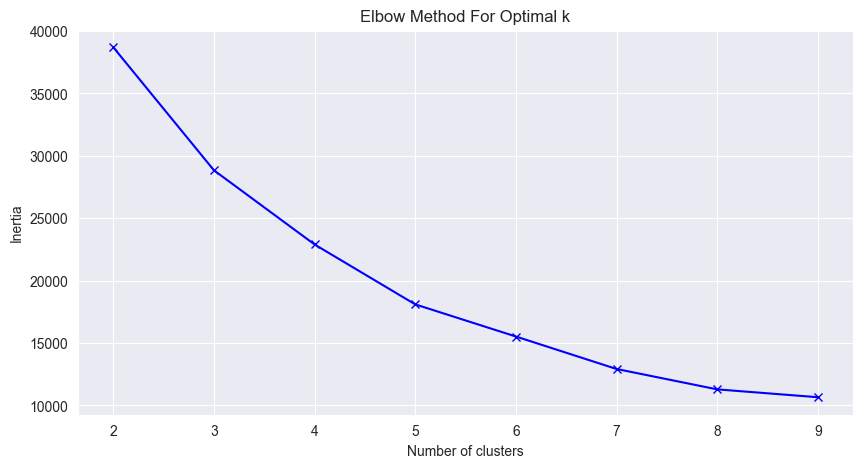

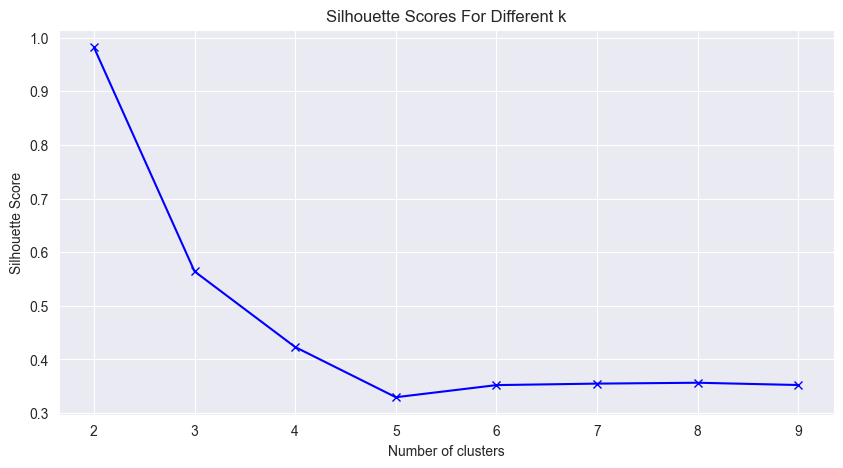

In [11]:
inertia = []
silhouette_scores = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

    # Calculate Silhouette Score
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 5))
plt.plot(K, inertia, "bx-")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method For Optimal k")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(K, silhouette_scores, "bx-")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores For Different k")
plt.show()

## Apply clustering with the optimal number of clusters

We will apply KMeans clustering using the optimal number of clusters determined by the elbow method and silhouette scores. This will create clusters based on stores with similar sales across categories. 

In [12]:
optimal_clusters = 6  # visual assessment

kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df["Cluster"] = kmeans.fit_predict(scaled_features)

silhouette_vals = silhouette_samples(scaled_features, df["Cluster"])
df["Silhouette Value"] = silhouette_vals

### Define default color palette to use in the plots

Folium -- a Python library for creating interactive maps -- only supports a limited number of colors. We will define a default color palette to use in the plots.

In [13]:
colors = {
    0: "red",
    1: "green",
    2: "blue",
    3: "pink",
    4: "orange",
    5: "purple",
    6: "lightred",
    7: "lightgreen",
    8: "lightblue",
    9: "darkred",
    10: "darkgreen",
    11: "darkblue",
    12: "darkpurple",
    13: "cadetblue",
    14: "beige",
    15: "lightgray",
    16: "gray",
    17: "black",
    18: "white",
}

## Silhouette plot

To confirm our clusters are well-formed, we will generate a silhouette plot that displays how well individual points are separated from other clusters and how tightly they are grouped within their own cluster. Each bar in the plot represents a point’s silhouette score, with longer bars indicating better fit within their cluster. The vertical Silhouette coefficient line indicates the average silhouette score across all clusters.

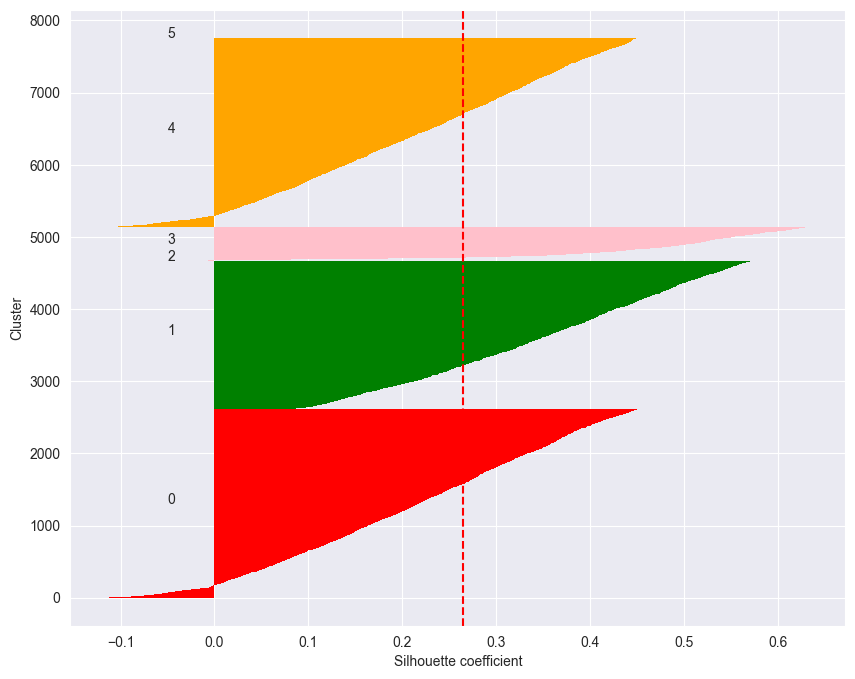

In [14]:
plt.figure(figsize=(10, 8))
y_lower, y_upper = 0, 0

for i in range(optimal_clusters):
    cluster_silhouette_vals = silhouette_vals[df["Cluster"] == i]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)

    plt.barh(
        range(y_lower, y_upper),
        cluster_silhouette_vals,
        edgecolor="none",
        height=1,
        color=colors[i],
    )
    plt.text(-0.05, (y_lower + y_upper) / 2, str(i))
    y_lower = y_upper

plt.xlabel("Silhouette coefficient")
plt.ylabel("Cluster")
plt.axvline(silhouette_vals.mean(), color="red", linestyle="--")
plt.show()

## Analyze the Clusters

We will analyze the clusters by calculating the average sales of each product category in each cluster and plotting them on a radar plot to visualize how different clusters of stores perform in various product categories.

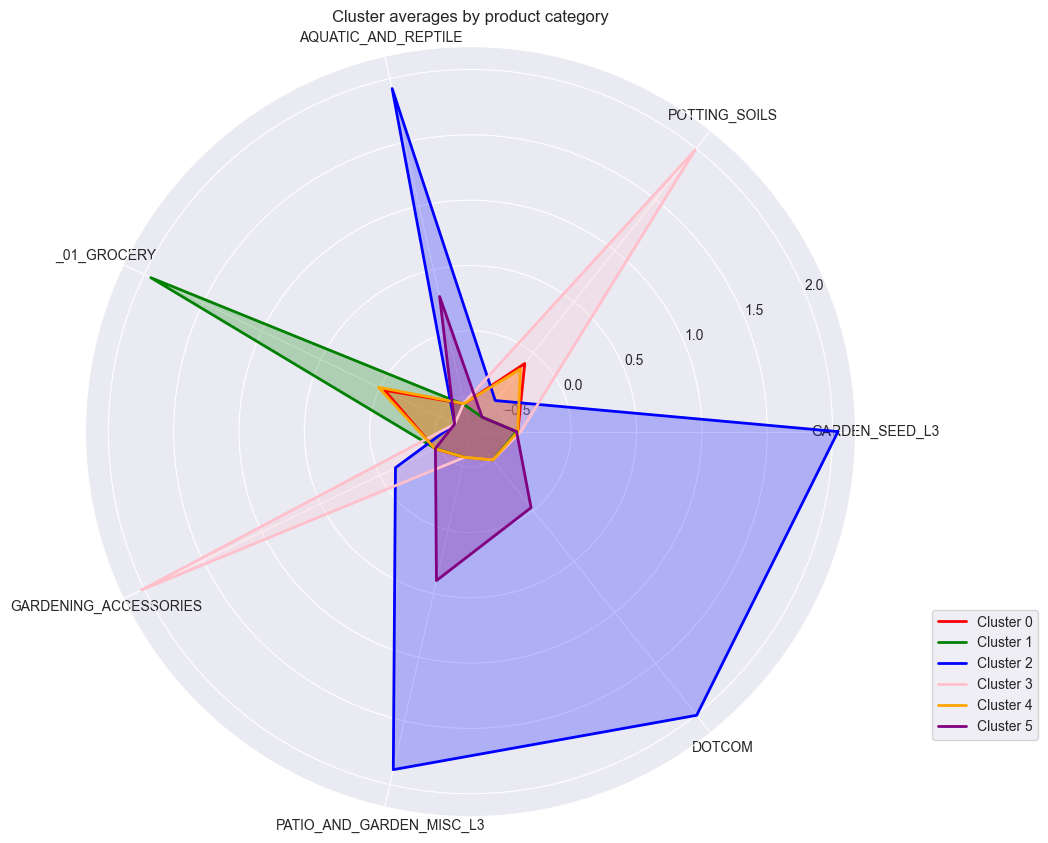

In [15]:
centroids = (
    df.groupby("Cluster")
    .mean()
    .drop("store_id", axis=1)
    .drop("Silhouette Value", axis=1)
    .drop("t-SNE1", axis=1, errors="ignore")
    .drop("t-SNE2", axis=1, errors="ignore")
)

centroids_normalized = (centroids - centroids.mean()) / centroids.std()

n_clusters = centroids_normalized.shape[0]
n_features = centroids_normalized.shape[1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

labels = centroids_normalized.columns
angles = np.linspace(0, 2 * np.pi, n_features, endpoint=False).tolist()
angles += angles[:1]

for i in range(n_clusters):
    values = centroids_normalized.loc[i].values.tolist()
    values += values[:1]
    ax.fill(angles, values, color=colors[i], alpha=0.25)
    ax.plot(angles, values, color=colors[i], linewidth=2, label=f"Cluster {i}")

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)

plt.title("Cluster averages by product category")
plt.legend(loc=(1.1, 0.1))

plt.show()

## Reduce the Dimensionality of the Data using t-SNE

To make it easier to see patterns and differences among the clusters, we can reduce the dimensionality of the data (i.e., plot the stores as groups rather than individually, while still preserving the relationships that formed the clusters as much as possible). In this example, we will use the t-SNE dimensionality reduction technique, as it is particularly well-suited for the visualization of high-dimensional datasets like this one.

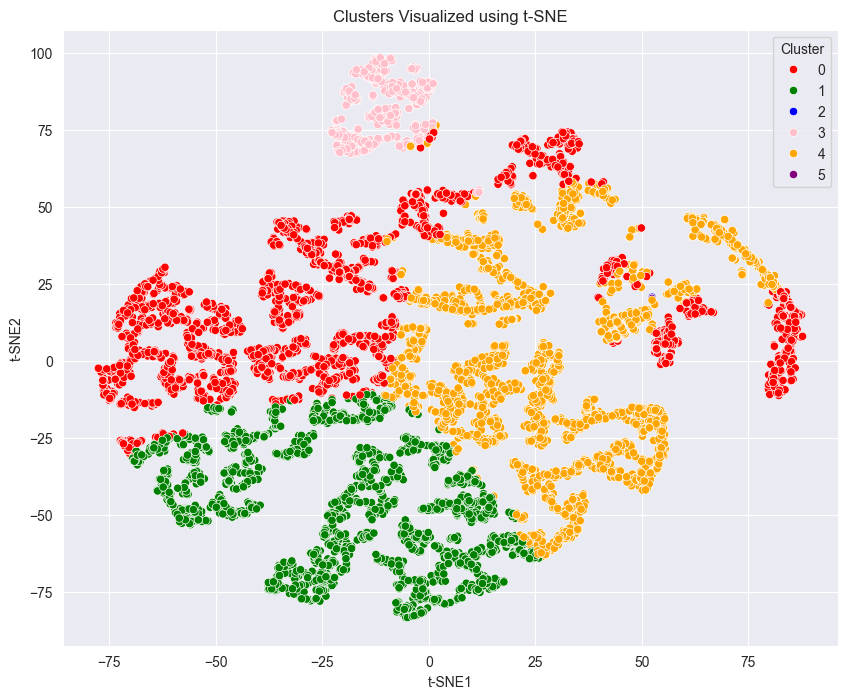

In [16]:
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(scaled_features)
df["t-SNE1"] = tsne_features[:, 0]
df["t-SNE2"] = tsne_features[:, 1]

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x="t-SNE1", y="t-SNE2", hue="Cluster", palette=colors, data=df, legend="full"
)
plt.title("Clusters Visualized using t-SNE")
plt.show()

## Describe the Clusters

We will use the OpenAI API to generate descriptions of each cluster based on the cluster's main product categories (these categories are determined by their proximity to the cluster's centroid).

In [17]:
centroids_content = "\n\n".join(
    centroids_normalized.apply(
        lambda x: ", ".join(x.index + " " + x.round(2).astype(str)), axis=1
    )
)


class StoreCluster(BaseModel):
    id: int = Field(description="Cluster ID - numbering starts from 0")
    short_name: str = Field(description="Short name of the cluster")
    description: str = Field(description="Description of the cluster")
    key_categories: list[str] = Field(description="Key product categories")


class StoreClusters(BaseModel):
    clusters: list[StoreCluster]


model = ChatOpenAI(model_name="gpt-4o", temperature=0.0)

prompt = PromptTemplate(
    template="You are an assistant helping describe product clusters based on their centroids."
    "Create a SHORT name and synthetic description of each cluster."
    "Provide key categories only if they are distinct enough to be mentioned."
    "Cluster centroids (the first columns is the cluster id - use it in the response):\n\n"
    "{centroids}\n\n",
    input_variables=["centroids"],
)

structured_output_model = model.with_structured_output(StoreClusters)
chain = prompt | structured_output_model

response = chain.invoke({"centroids": centroids_content})
cluster_names = response.clusters

for cluster in cluster_names:
    print(f"Cluster {cluster.id}")
    print(f"   Short name: {cluster.short_name}")
    print(f"   Description: {cluster.description}")
    print(f"   Key categories: {cluster.key_categories}")

Cluster 0
   Short name: General Garden
   Description: A balanced cluster with no strong emphasis on any category, representing a general garden interest.
   Key categories: []
Cluster 1
   Short name: Grocery Focused
   Description: Primarily focused on grocery products with minimal interest in gardening and related categories.
   Key categories: ['_01_GROCERY']
Cluster 2
   Short name: Garden Enthusiasts
   Description: Strong interest in garden seeds, aquatic and reptile products, and patio and garden miscellaneous items.
   Key categories: ['GARDEN_SEED_L3', 'AQUATIC_AND_REPTILE', 'PATIO_AND_GARDEN_MISC_L3']
Cluster 3
   Short name: Gardening Accessories
   Description: High interest in potting soils and gardening accessories, with minimal focus on other categories.
   Key categories: ['POTTING_SOILS', 'GARDENING_ACCESSORIES']
Cluster 4
   Short name: Balanced Garden
   Description: A balanced cluster with slight emphasis on grocery products, representing a general garden interest

## Geographical distribution of clusters

We will plot the geographical distribution of the stores based on the clusters.

In [18]:
%%load store_df
SELECT
    store_id,
    retailer,
    store_longitude,
    store_latitude
FROM
    `{src_project}`.`{src_dataset}`.`{dim_store}`
WHERE
    store_longitude IS NOT NULL AND
    store_latitude IS NOT NULL
    AND store_longitude BETWEEN -78 AND -72
    AND store_latitude BETWEEN 40 AND 42

In [19]:
stores = store_df.merge(df, on="store_id").dropna()
center_lat = stores["store_latitude"].mean()
center_lon = stores["store_longitude"].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=6)

for _, row in stores.iterrows():
    folium.Marker(
        location=[row["store_latitude"], row["store_longitude"]],
        popup=f"Store ID: {row['store_id']}",
        tooltip=row["retailer"].upper(),
        icon=folium.Icon(color=colors[row["Cluster"]]),
    ).add_to(m)

# Add legend
legend_html = """
<div style="position: fixed;
        bottom: 20px; left: 20px; width: 300px; height: 280px;
        border:2px solid grey; z-index:9999; font-size:14px;
        background-color: white;
        opacity: 0.8;
        ">
"""
for cluster_num, cluster_name in enumerate(cluster_names):
    legend_html += f'<p style="margin: 10px"> <span style="color:{colors[cluster_num]}">{cluster_name.id}: {cluster_name.short_name}</span></p>'

legend_html += "</div>"
m.get_root().html.add_child(folium.Element(legend_html))

m